# Dependencies

In [1]:
!pip install ucimlrepo
!pip install scikit-learn

In [2]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, mean_absolute_error, log_loss, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import validation_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import numpy as np

# Data Preparation

In [3]:
# fetch dataset 
ai4i_2020_predictive_maintenance_dataset = fetch_ucirepo(id=601) 
  
# data (as pandas dataframes) 
X = ai4i_2020_predictive_maintenance_dataset.data.features 
y = ai4i_2020_predictive_maintenance_dataset.data.targets 

In [4]:
# Check feature data
X.head()

Type  Air temperature  Process temperature  Rotational speed  Torque  \
0    M            298.1                308.6              1551    42.8   
1    L            298.2                308.7              1408    46.3   
2    L            298.1                308.5              1498    49.4   
3    L            298.2                308.6              1433    39.5   
4    L            298.2                308.7              1408    40.0   

   Tool wear  
0          0  
1          3  
2          5  
3          7  
4          9

In [5]:
# Convert categorical data into numerical representation
X.loc[X['Type'] == 'L', 'Type'] = 0
X.loc[X['Type'] == 'M', 'Type'] = 1
X.loc[X['Type'] == 'H', 'Type'] = 2
X.head()

Type  Air temperature  Process temperature  Rotational speed  Torque  \
0    1            298.1                308.6              1551    42.8   
1    0            298.2                308.7              1408    46.3   
2    0            298.1                308.5              1498    49.4   
3    0            298.2                308.6              1433    39.5   
4    0            298.2                308.7              1408    40.0   

   Tool wear  
0          0  
1          3  
2          5  
3          7  
4          9

In [6]:
# Check targets data
y.head()

Machine failure  TWF  HDF  PWF  OSF  RNF
0                0    0    0    0    0    0
1                0    0    0    0    0    0
2                0    0    0    0    0    0
3                0    0    0    0    0    0
4                0    0    0    0    0    0

In [7]:
# Get Machine failure data
y_fail = y['Machine failure']
y_fail.head()

0    0
1    0
2    0
3    0
4    0
Name: Machine failure, dtype: int64

array([[<Axes: title={'center': 'Air temperature'}>,
        <Axes: title={'center': 'Process temperature'}>],
       [<Axes: title={'center': 'Rotational speed'}>,
        <Axes: title={'center': 'Torque'}>],
       [<Axes: title={'center': 'Tool wear'}>, <Axes: >]], dtype=object)

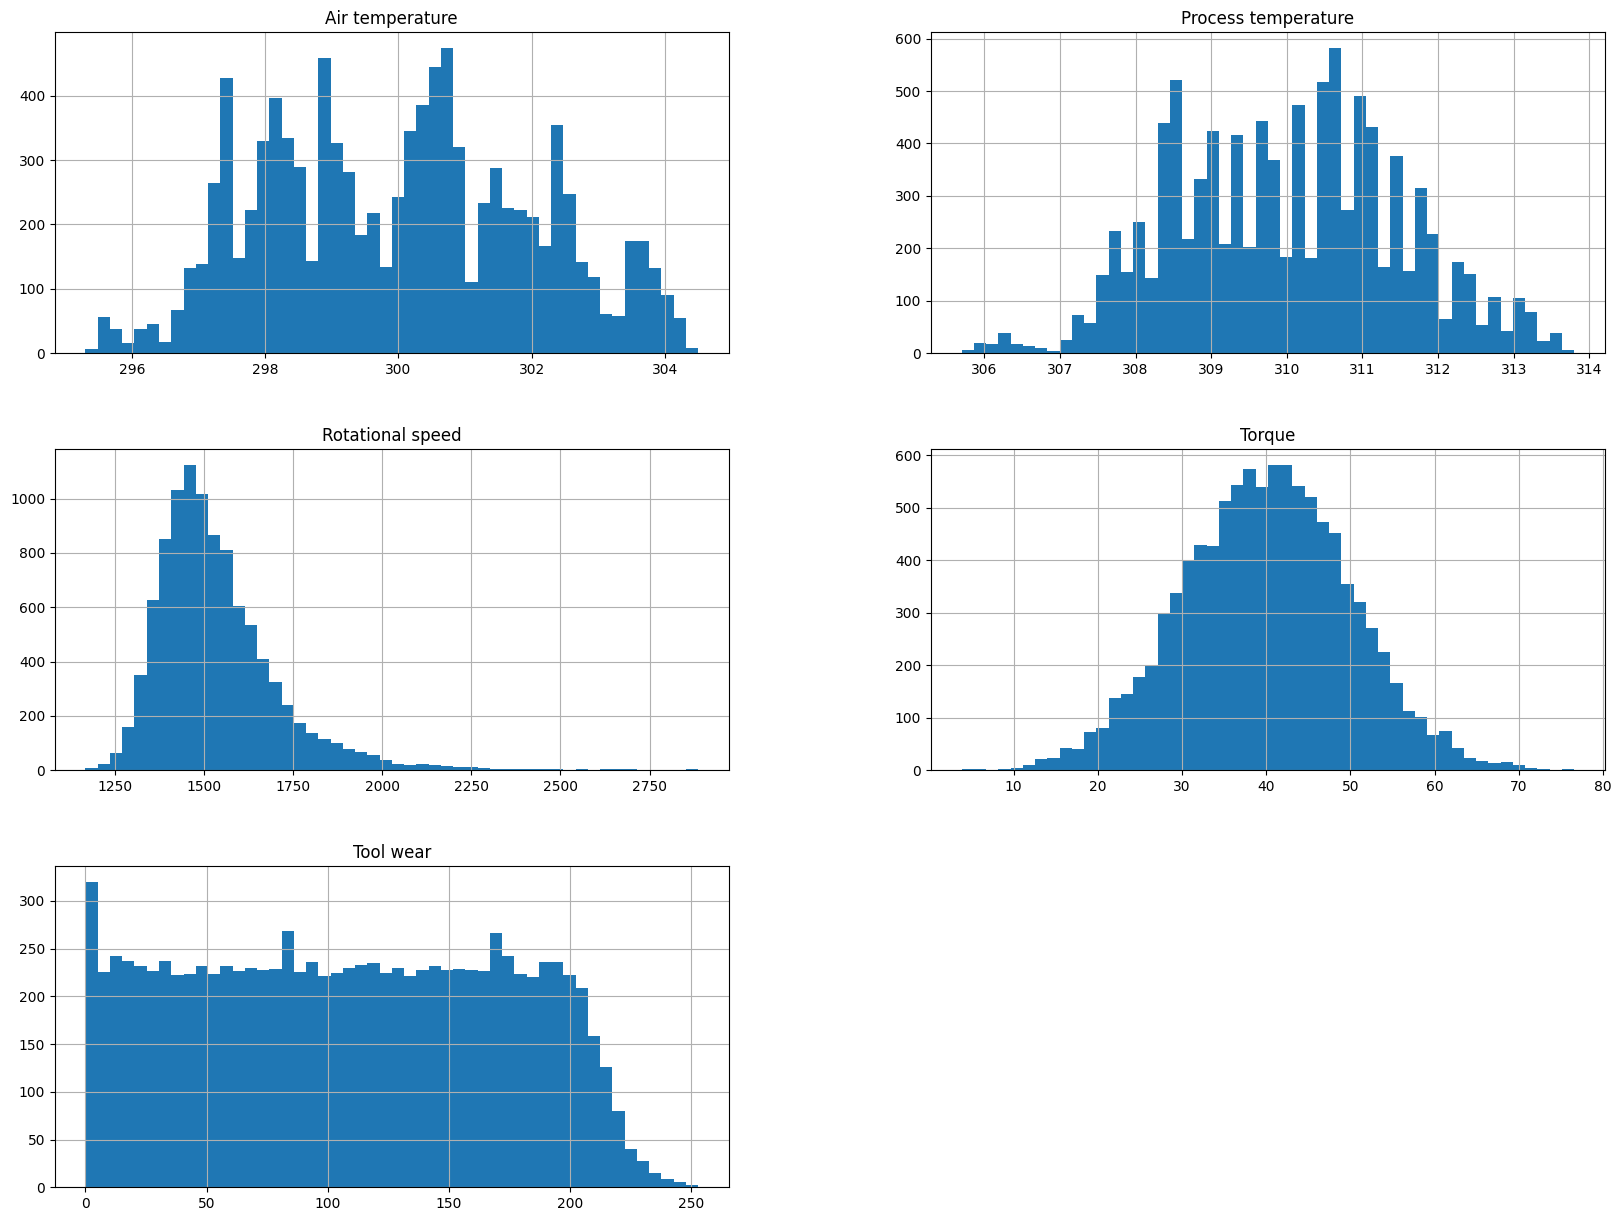

In [8]:
# Check how feature data looks like to get more understanding of data
X.hist(bins=50, figsize=(20,15))

In [9]:
X.describe()

Air temperature  Process temperature  Rotational speed        Torque  \
count     10000.000000         10000.000000      10000.000000  10000.000000   
mean        300.004930           310.005560       1538.776100     39.986910   
std           2.000259             1.483734        179.284096      9.968934   
min         295.300000           305.700000       1168.000000      3.800000   
25%         298.300000           308.800000       1423.000000     33.200000   
50%         300.100000           310.100000       1503.000000     40.100000   
75%         301.500000           311.100000       1612.000000     46.800000   
max         304.500000           313.800000       2886.000000     76.600000   

          Tool wear  
count  10000.000000  
mean     107.951000  
std       63.654147  
min        0.000000  
25%       53.000000  
50%      108.000000  
75%      162.000000  
max      253.000000

In [10]:
y_fail.describe()

count    10000.000000
mean         0.033900
std          0.180981
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Machine failure, dtype: float64

In [11]:
# Split data set into training and test sets
# Apply random seed to allow repetition of output
# Apply stratify to get good representation of failure and non-failure between training and test sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y_fail, test_size=0.2, random_state=1, shuffle=True, stratify=y_fail)

# Checking split if stratified
print(ytrain.value_counts())
print(ytest.value_counts())
print(ytrain.value_counts()/ytest.value_counts()) # values of 0 and 1 should be similar for this ratio.

Machine failure
0    7729
1     271
Name: count, dtype: int64
Machine failure
0    1932
1      68
Name: count, dtype: int64
Machine failure
0    4.000518
1    3.985294
Name: count, dtype: float64


In [12]:
# Apply Feature scaling to transform the scaling of different features into similar scales.
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

# Functions

In [15]:
def confuse_matrix(ytest, ypred):
    '''
    Compute the confusion matrix
    [[TN   FP]  # True Negatives (TN), False Positives (FP)
     [  FN   TP]] # False Negatives (FN), True Positives (TP)
    '''
    cm = confusion_matrix(ytest, ypred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                 display_labels=['Class 0', 'Class 1'])
    
    fig, ax = plt.subplots(figsize=(4, 3))
    disp.plot(ax=ax, cmap='Blues', values_format='d')

# KNN Implementation

In [16]:
# KNN Basic Implementation Form - n=2
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(xtrain, ytrain)
ypred = knn.predict(xtest)
ypred_prob = knn.predict_proba(xtest)
accuracy = accuracy_score(ytest, ypred)
print('Accuracy:', accuracy)
precision = precision_score(ytest, ypred)
print('Precision:', precision)
recall = recall_score(ytest, ypred)
print('Recall:', recall)

Accuracy: 0.9665
Precision: 0.5263157894736842
Recall: 0.14705882352941177


In [17]:
# Validation Curve kNN 2-50
knn = KNeighborsClassifier()
values = np.arange(2,50, 1)
estimator = knn
param_name, param_range = 'n_neighbors', values
scoring = 'recall'
train_scores, val_scores = validation_curve(estimator, xtrain, ytrain, param_name=param_name, 
                                                 param_range=param_range, scoring=scoring, cv=5)
mean_train_score = np.mean(train_scores, axis=1)
mean_val_scores = np.mean(val_scores, axis=1)

In [18]:
# Get best k parameter
best_k_params = values[mean_val_scores.tolist().index(max(mean_val_scores.tolist()))]
print('Best k: ' + str(best_k_params))

Best k: 3


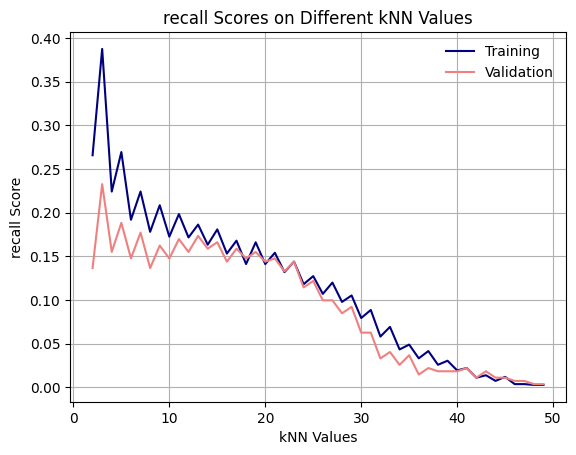

In [19]:
# Plot validation curve
plt.figure(scoring)
plt.plot(values, mean_train_score, label='Training', color='navy')
plt.plot(values, mean_val_scores, label='Validation', color='lightcoral')
plt.xlabel('kNN Values')
plt.ylabel(str(scoring) + ' Score')
plt.title(str(scoring) + ' Scores on Different kNN Values')
plt.grid(visible=True)
plt.legend(frameon=False)

In [20]:
# Apply optimal hyperparameter from validation curve
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain, ytrain)
ypred_knn = knn.predict(xtest)
ypred_prob = knn.predict_proba(xtest)
accuracy_knn = accuracy_score(ytest, ypred_knn)
print('Accuracy:', accuracy_knn)
precision_knn = precision_score(ytest, ypred_knn)
print('Precision:', precision_knn)
recall_knn = recall_score(ytest, ypred_knn)
print('Recall:', recall_knn)

Accuracy: 0.967
Precision: 0.53125
Recall: 0.25


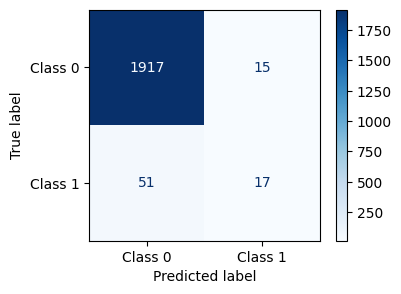

In [21]:
# Compute the confusion matrix
confuse_matrix(ytest, ypred_knn)

In [22]:
# Add labels of confusion matrix
x_knn = xtest.copy()
x_knn
x_knn.loc[(ypred_knn==0) & (ytest==0), 'knn'] = 'True negative'
x_knn.loc[(ypred_knn==1) & (ytest==0), 'knn'] = 'False positive'
x_knn.loc[(ypred_knn==0) & (ytest==1), 'knn'] = 'False negative'
x_knn.loc[(ypred_knn==1) & (ytest==1), 'knn'] = 'True positive'

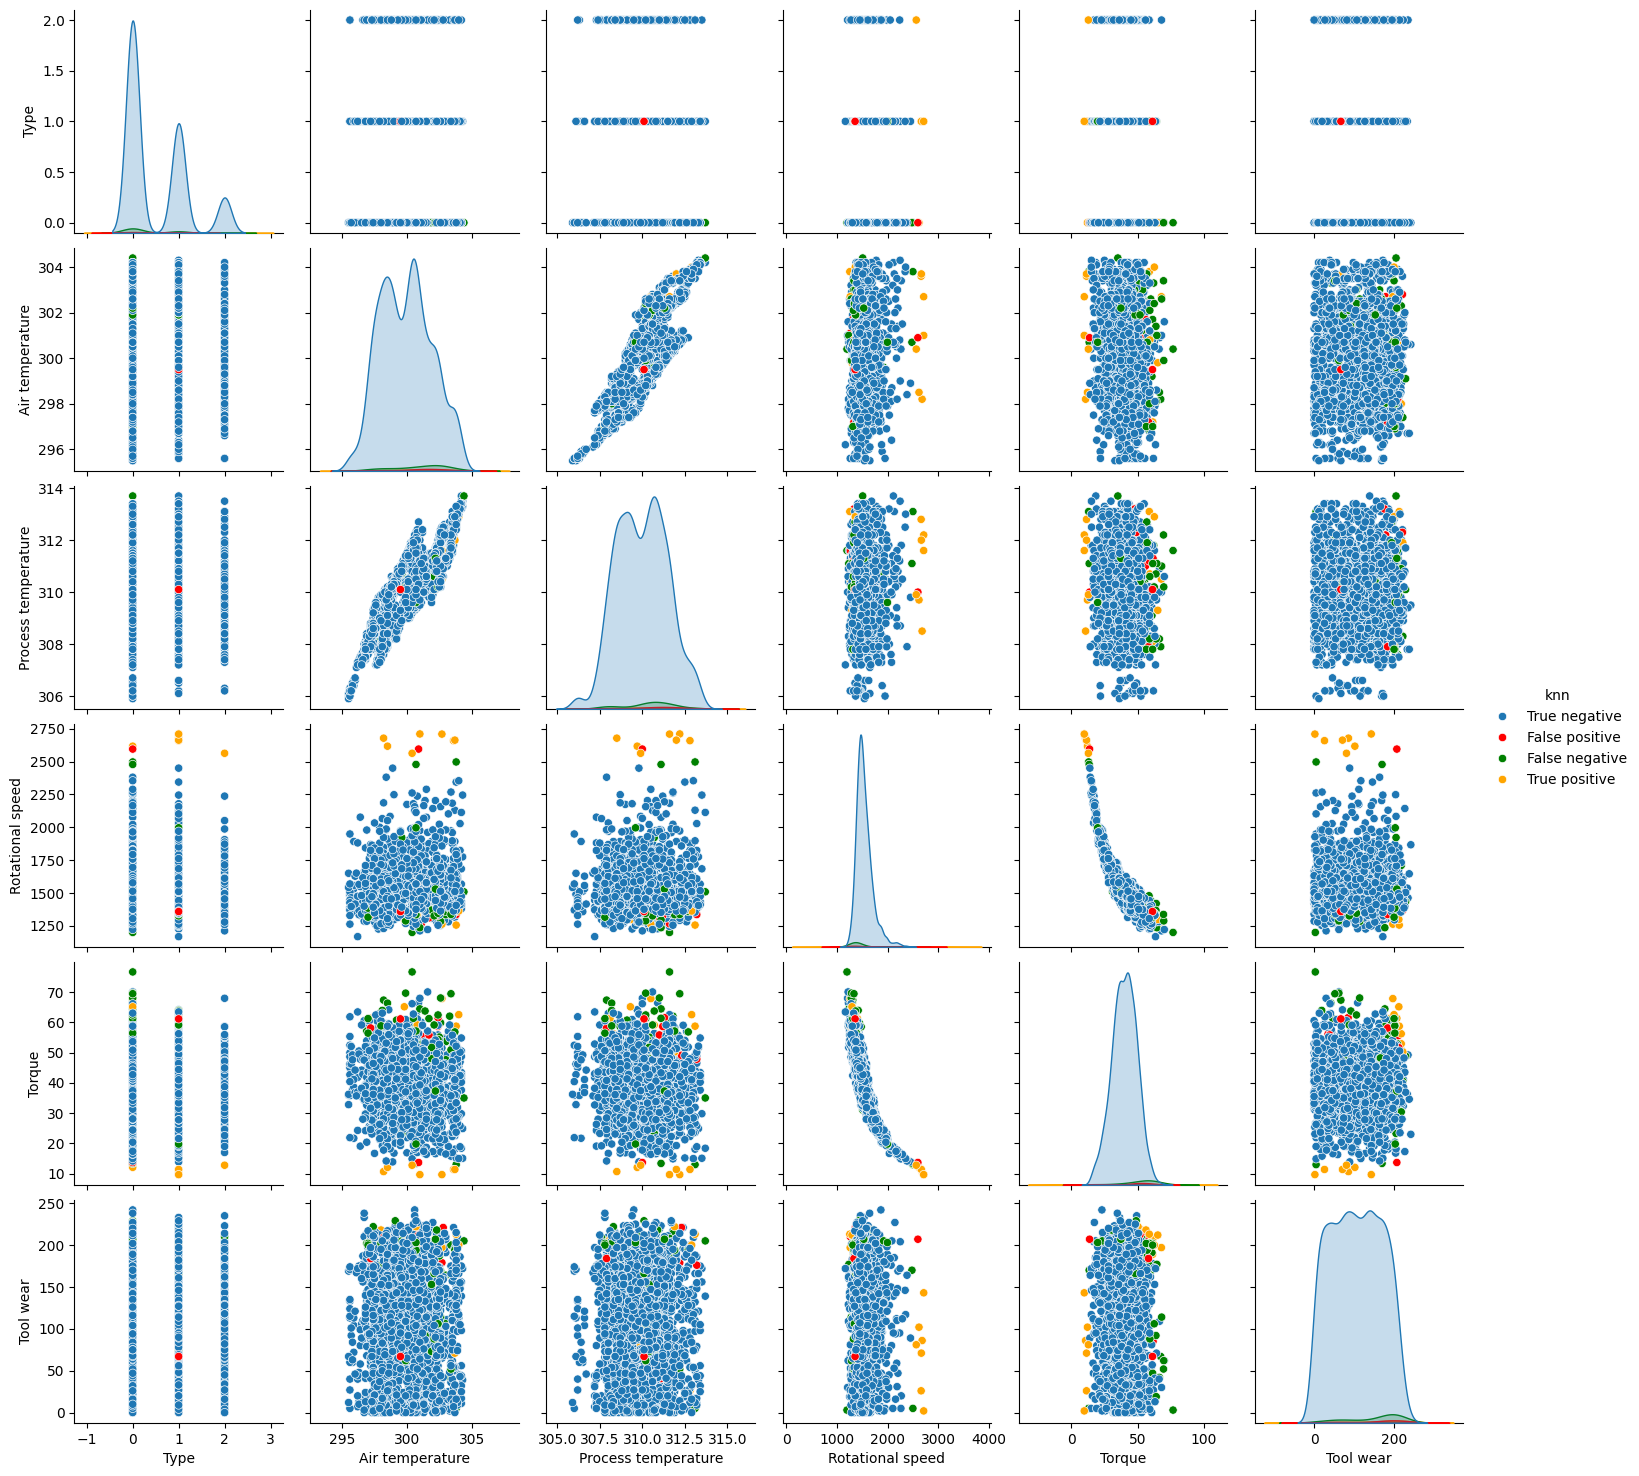

In [23]:
# Plot feature pairs
sns.pairplot(x_knn, 
             hue='knn', 
             hue_order=['True negative', 'False positive','False negative', 'True positive'],
             palette=['#1f77b4', 'red', 'green', 'orange'])

# Decision Tree Implementation

In [24]:
# Decision Tree Basic Implementation Form 
dtree = tree.DecisionTreeClassifier()
dtree_fit = dtree.fit(xtrain, ytrain)
ypred_dtree = dtree_fit.predict(xtest)
ypred_prob = dtree_fit.predict_proba(xtest)
accuracy_dtree = accuracy_score(ytest, ypred_dtree)
print('Accuracy:', accuracy_dtree)
precision_dtree = precision_score(ytest, ypred_dtree)
print('Precision:', precision_dtree)
recall_dtree = recall_score(ytest, ypred_dtree)
print('Recall:', recall_dtree)


Accuracy: 0.977
Precision: 0.6617647058823529
Recall: 0.6617647058823529


In [25]:
# Hyperparameter Tuning of Decision Tree 
# Define the parameter grid to tune the hyperparameters
param_grid = {
    'max_depth': [10, 20, 30, None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#Perform grid search from hyperparameters to find optimal performance
dtree = tree.DecisionTreeClassifier()
grid_search_dtree = GridSearchCV(estimator=dtree, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='recall')
grid_search_dtree.fit(xtrain, ytrain)
print('best score: {:.3f}, best params: {}'.format(grid_search_dtree.best_score_, grid_search_dtree.best_params_))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
best score: 0.724, best params: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [26]:
# Provide top 5 from grid search table and best parameters.
gs_table = pd.DataFrame(grid_search_dtree.cv_results_)
gs_sort = gs_table.sort_values('rank_test_score', ascending=True)
gs_sort.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
18       0.060895      0.002065         0.010066        0.001536   
27       0.059083      0.005744         0.010805        0.001630   
29       0.054359      0.005029         0.009812        0.001983   
20       0.060842      0.002846         0.009746        0.001261   
99       0.062079      0.009131         0.015895        0.009991   

   param_criterion param_max_depth  param_min_samples_leaf  \
18            gini              30                       1   
27            gini            None                       1   
29            gini            None                       1   
20            gini              30                       1   
99        log_loss            None                       1   

    param_min_samples_split  \
18                        2   
27                        2   
29                       10   
20                       10   
99                        2   

                                               params  split0_test_score  \
18  {'criterion': 'gini', 'max_depth': 30, 'min_sa...           0.796296   
27  {'criterion': 'gini', 'max_depth': None, 'min_...           0.777778   
29  {'criterion': 'gini', 'max_depth': None, 'min_...           0.796296   
20  {'criterion': 'gini', 'max_depth': 30, 'min_sa...           0.796296   
99  {'criterion': 'log_loss', 'max_depth': None, '...           0.722222   

    split1_test_score  split2_test_score  split3_test_score  \
18           0.740741           0.685185           0.796296   
27           0.666667           0.703704           0.796296   
29           0.666667           0.685185           0.759259   
20           0.666667           0.666667           0.759259   
99           0.796296           0.648148           0.759259   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
18           0.600000         0.723704        0.074318                1  
27           0.618182         0.712525        0.066869                2  
29           0.636364         0.708754        0.059635                3  
20           0.636364         0.705051        0.061529                4  
99           0.581818         0.701549        0.077359                5

In [27]:
# Apply optimal hyperparameter from grid search
best_dtree = grid_search_dtree.best_estimator_
ypred_dtree = best_dtree.predict(xtest)
accuracy_dtree = accuracy_score(ytest, ypred_dtree)
print('Accuracy:', accuracy_dtree)
precision_dtree = precision_score(ytest, ypred_dtree)
print('Precision:', precision_dtree)
recall_dtree = recall_score(ytest, ypred_dtree)
print('Recall:', recall_dtree)


Accuracy: 0.9735
Precision: 0.6119402985074627
Recall: 0.6029411764705882


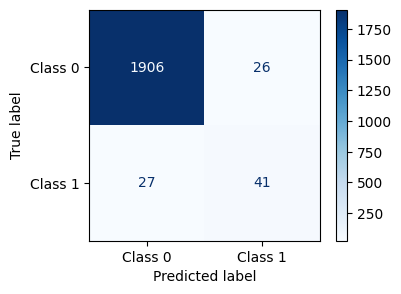

In [28]:
# Compute the confusion matrix
confuse_matrix(ytest, ypred_dtree)

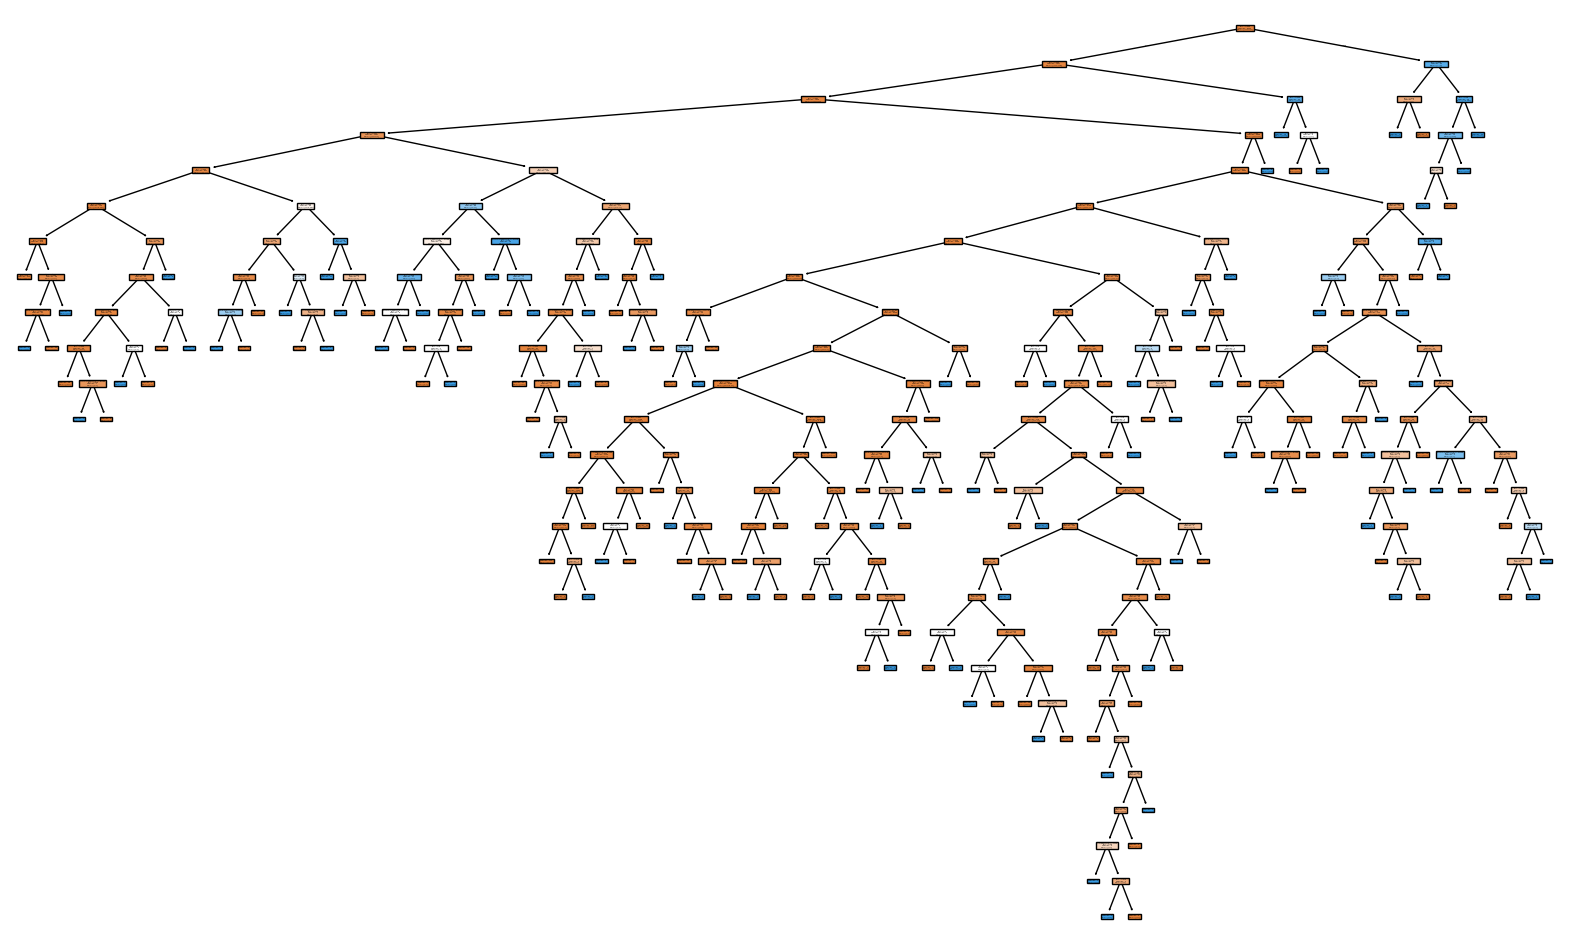

In [29]:
# Plotting entire decision tree
plt.figure(figsize=(20, 12))
tree.plot_tree(best_dtree,               
               filled=True, 
               feature_names=X.columns)
plt.show()

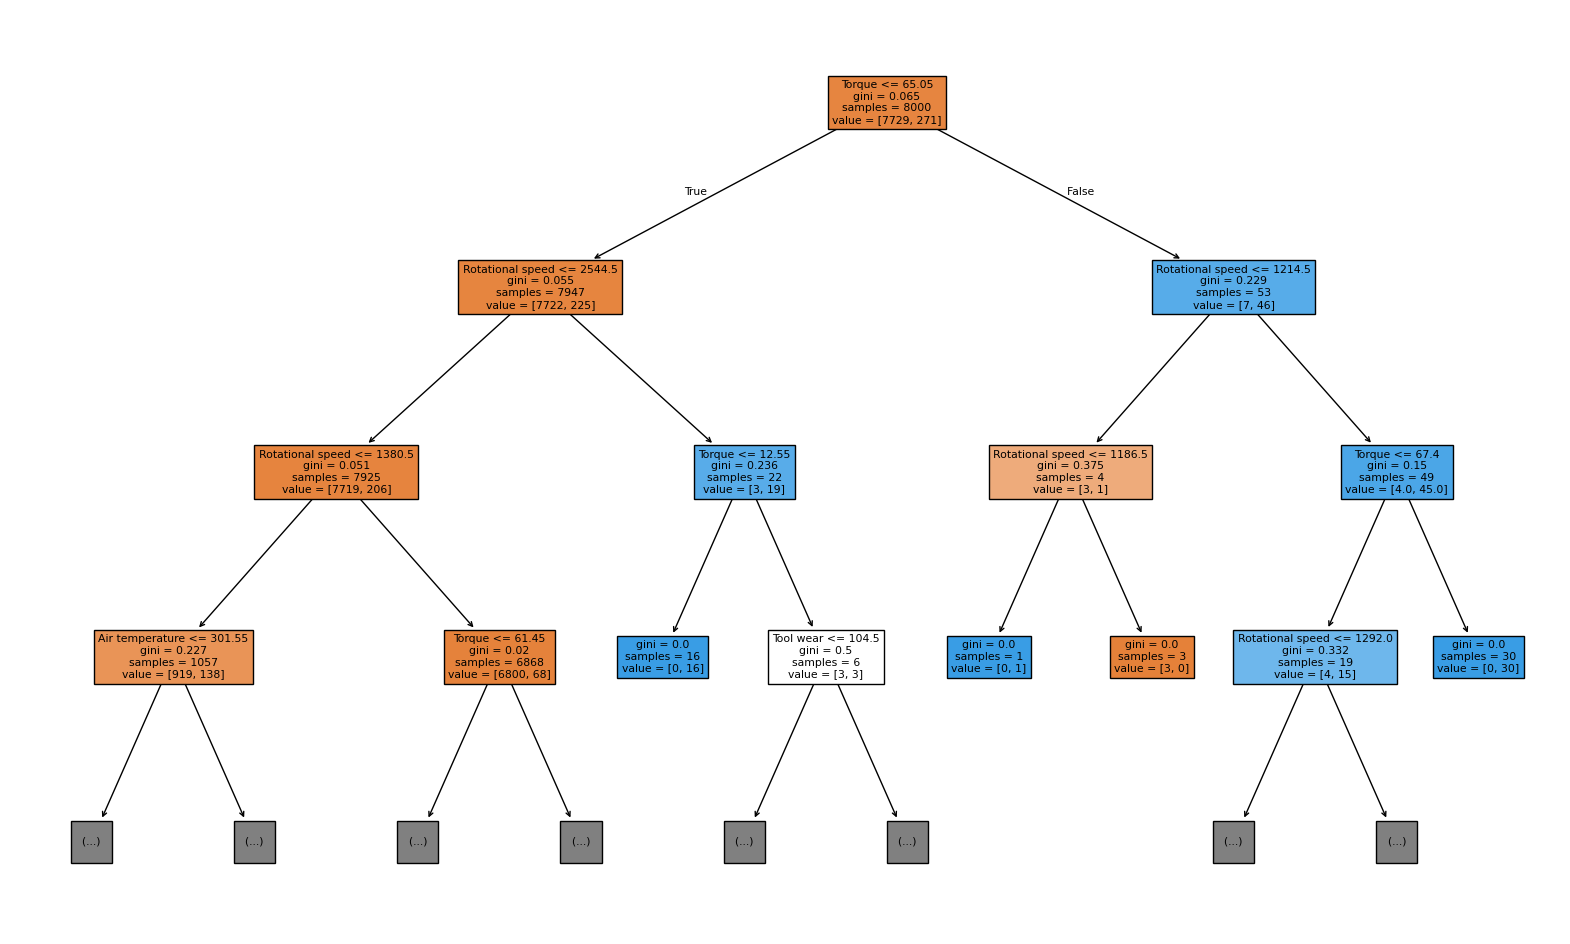

In [30]:
# Plotting decision tree with depth 3
plt.figure(figsize=(20, 12))
tree.plot_tree(best_dtree, 
               max_depth=3,              # Only show first 3 levels
               filled=True, 
               feature_names=X.columns)
plt.show()

In [31]:
x_dtree = xtest.copy()
x_dtree.loc[(ypred_dtree==0) & (ytest==0), 'Decision Tree'] = 'True negative'
x_dtree.loc[(ypred_dtree==1) & (ytest==0), 'Decision Tree'] = 'False positive'
x_dtree.loc[(ypred_dtree==0) & (ytest==1), 'Decision Tree'] = 'False negative'
x_dtree.loc[(ypred_dtree==1) & (ytest==1), 'Decision Tree'] = 'True positive'

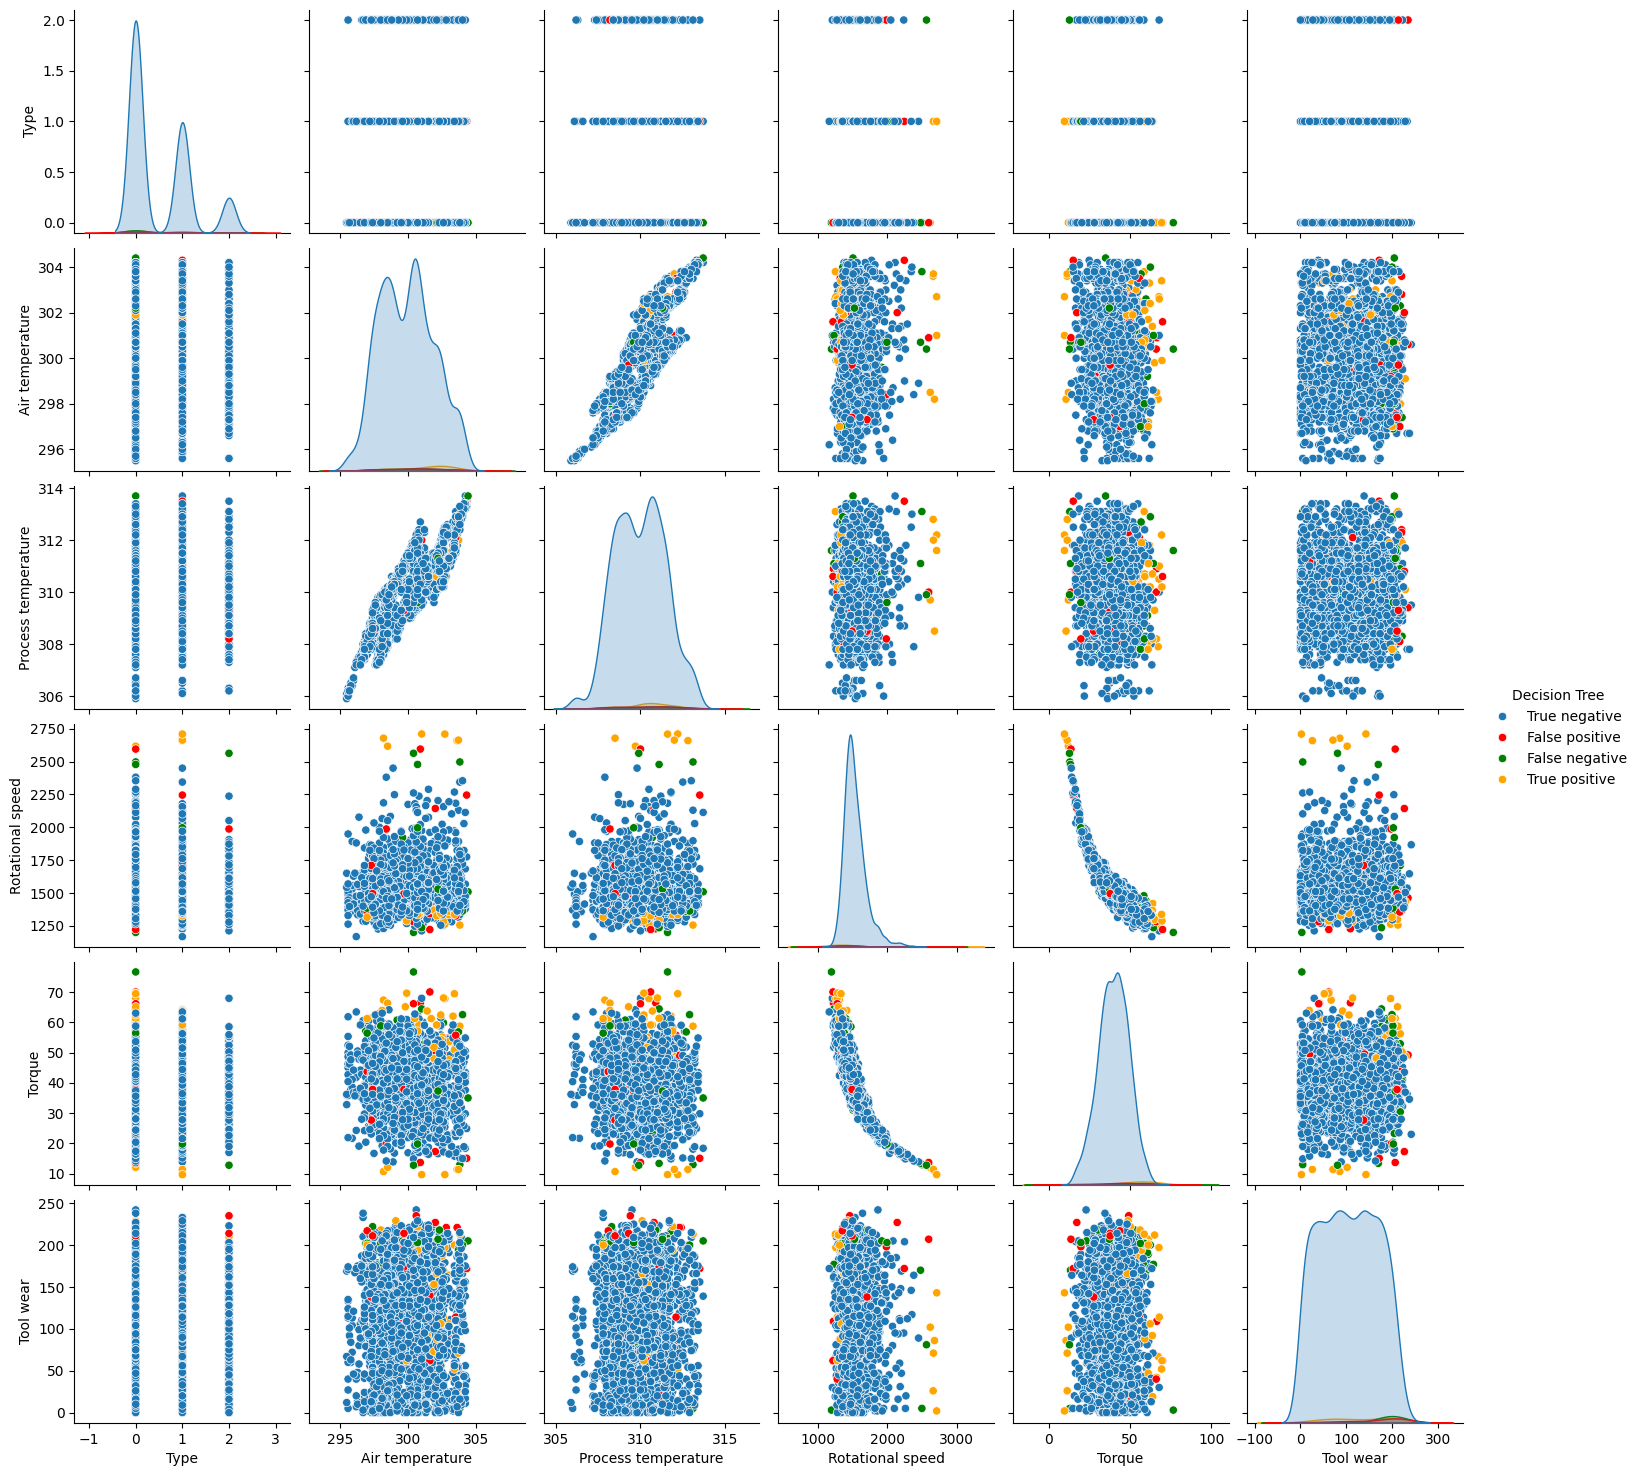

In [32]:
# Plot feature pairs
sns.pairplot(x_dtree, 
             hue='Decision Tree', 
             hue_order=['True negative', 'False positive','False negative', 'True positive'],
             palette=['#1f77b4', 'red', 'green', 'orange'])

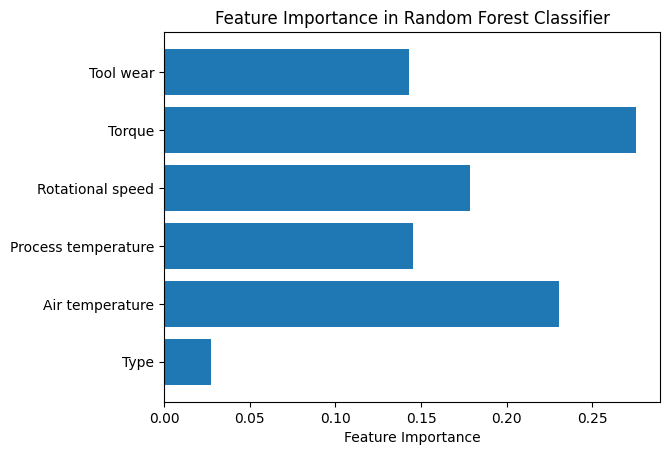

In [33]:
feature_importances = best_dtree.feature_importances_

plt.barh(xtrain.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

# Random Forest Implementation

In [34]:
# Random Forest Basic Implementation Form 
rforest = RandomForestClassifier(n_estimators=100)
rforest.fit(xtrain, ytrain)
ypred_rforest = rforest.predict(xtest)
ypred_prob = rforest.predict_proba(xtest)
accuracy_rforest = accuracy_score(ytest, ypred_rforest)
print('Accuracy:', accuracy_rforest)
precision_rforest = precision_score(ytest, ypred_rforest)
print('Precision:', precision_rforest)
recall_rforest = recall_score(ytest, ypred_rforest)
print('Recall:', recall_rforest)


Accuracy: 0.9795
Precision: 0.8292682926829268
Recall: 0.5


In [35]:
# Hyperparameter Tuning of Random Forest 
# Define the parameter grid to tune the hyperparameters
param_grid = {
    'n_estimators': [10, 20, 50, 100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 4, 8],
    'bootstrap': [True, False]
}

#Perform grid search from hyperparameters to find optimal performance
rforest = RandomForestClassifier()
grid_search_rforest = GridSearchCV(estimator=rforest, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='recall')
grid_search_rforest.fit(xtrain, ytrain)
print('best score: {:.3f}, best params: {}'.format(grid_search_rforest.best_score_, grid_search_rforest.best_params_))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
best score: 0.661, best params: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 4, 'n_estimators': 50}


In [36]:
# Provide top 5 from grid search table and best parameters.
gs_table = pd.DataFrame(grid_search_rforest.cv_results_)
gs_sort = gs_table.sort_values('rank_test_score', ascending=True)
gs_sort.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
174       0.984598      0.055928         0.026960        0.001749   
185       0.378680      0.024982         0.015449        0.001444   
158       1.174027      0.032113         0.026471        0.003548   
162       0.887310      0.047674         0.024640        0.002714   
163       1.841330      0.122836         0.039132        0.003495   

     param_bootstrap param_criterion param_max_depth  param_min_samples_split  \
174            False            gini              30                        4   
185            False            gini            None                        4   
158            False            gini              20                        2   
162            False            gini              20                        4   
163            False            gini              20                        4   

     param_n_estimators                                             params  \
174                  50  {'bootstrap': False, 'criterion': 'gini', 'max...   
185                  20  {'bootstrap': False, 'criterion': 'gini', 'max...   
158                  50  {'bootstrap': False, 'criterion': 'gini', 'max...   
162                  50  {'bootstrap': False, 'criterion': 'gini', 'max...   
163                 100  {'bootstrap': False, 'criterion': 'gini', 'max...   

     split0_test_score  split1_test_score  split2_test_score  \
174           0.740741           0.703704           0.611111   
185           0.685185           0.703704           0.592593   
158           0.703704           0.703704           0.611111   
162           0.740741           0.703704           0.629630   
163           0.722222           0.685185           0.611111   

     split3_test_score  split4_test_score  mean_test_score  std_test_score  \
174           0.685185           0.563636         0.660875        0.064398   
185           0.740741           0.563636         0.657172        0.067606   
158           0.740741           0.509091         0.653670        0.084027   
162           0.666667           0.527273         0.653603        0.073223   
163           0.703704           0.545455         0.653535        0.065906   

     rank_test_score  
174                1  
185                2  
158                3  
162                4  
163                5

In [37]:
# Apply optimal hyperparameter from grid search
best_rforest = grid_search_rforest.best_estimator_
ypred_rforest = best_rforest.predict(xtest)
accuracy_rforest = accuracy_score(ytest, ypred_rforest)
print('Accuracy:', accuracy_rforest)
precision_rforest = precision_score(ytest, ypred_rforest)
print('Precision:', precision_rforest)
recall_rforest = recall_score(ytest, ypred_rforest)
print('Recall:', recall_rforest)

Accuracy: 0.9805
Precision: 0.7843137254901961
Recall: 0.5882352941176471


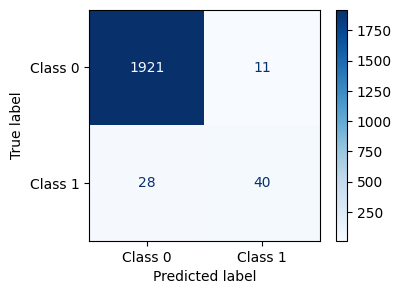

In [38]:
# Compute the confusion matrix
confuse_matrix(ytest, ypred_rforest)

In [39]:
x_rforest = xtest.copy()
x_rforest.loc[(ypred_rforest==0) & (ytest==0), 'Random Forest'] = 'True negative'
x_rforest.loc[(ypred_rforest==1) & (ytest==0), 'Random Forest'] = 'False positive'
x_rforest.loc[(ypred_rforest==0) & (ytest==1), 'Random Forest'] = 'False negative'
x_rforest.loc[(ypred_rforest==1) & (ytest==1), 'Random Forest'] = 'True positive'

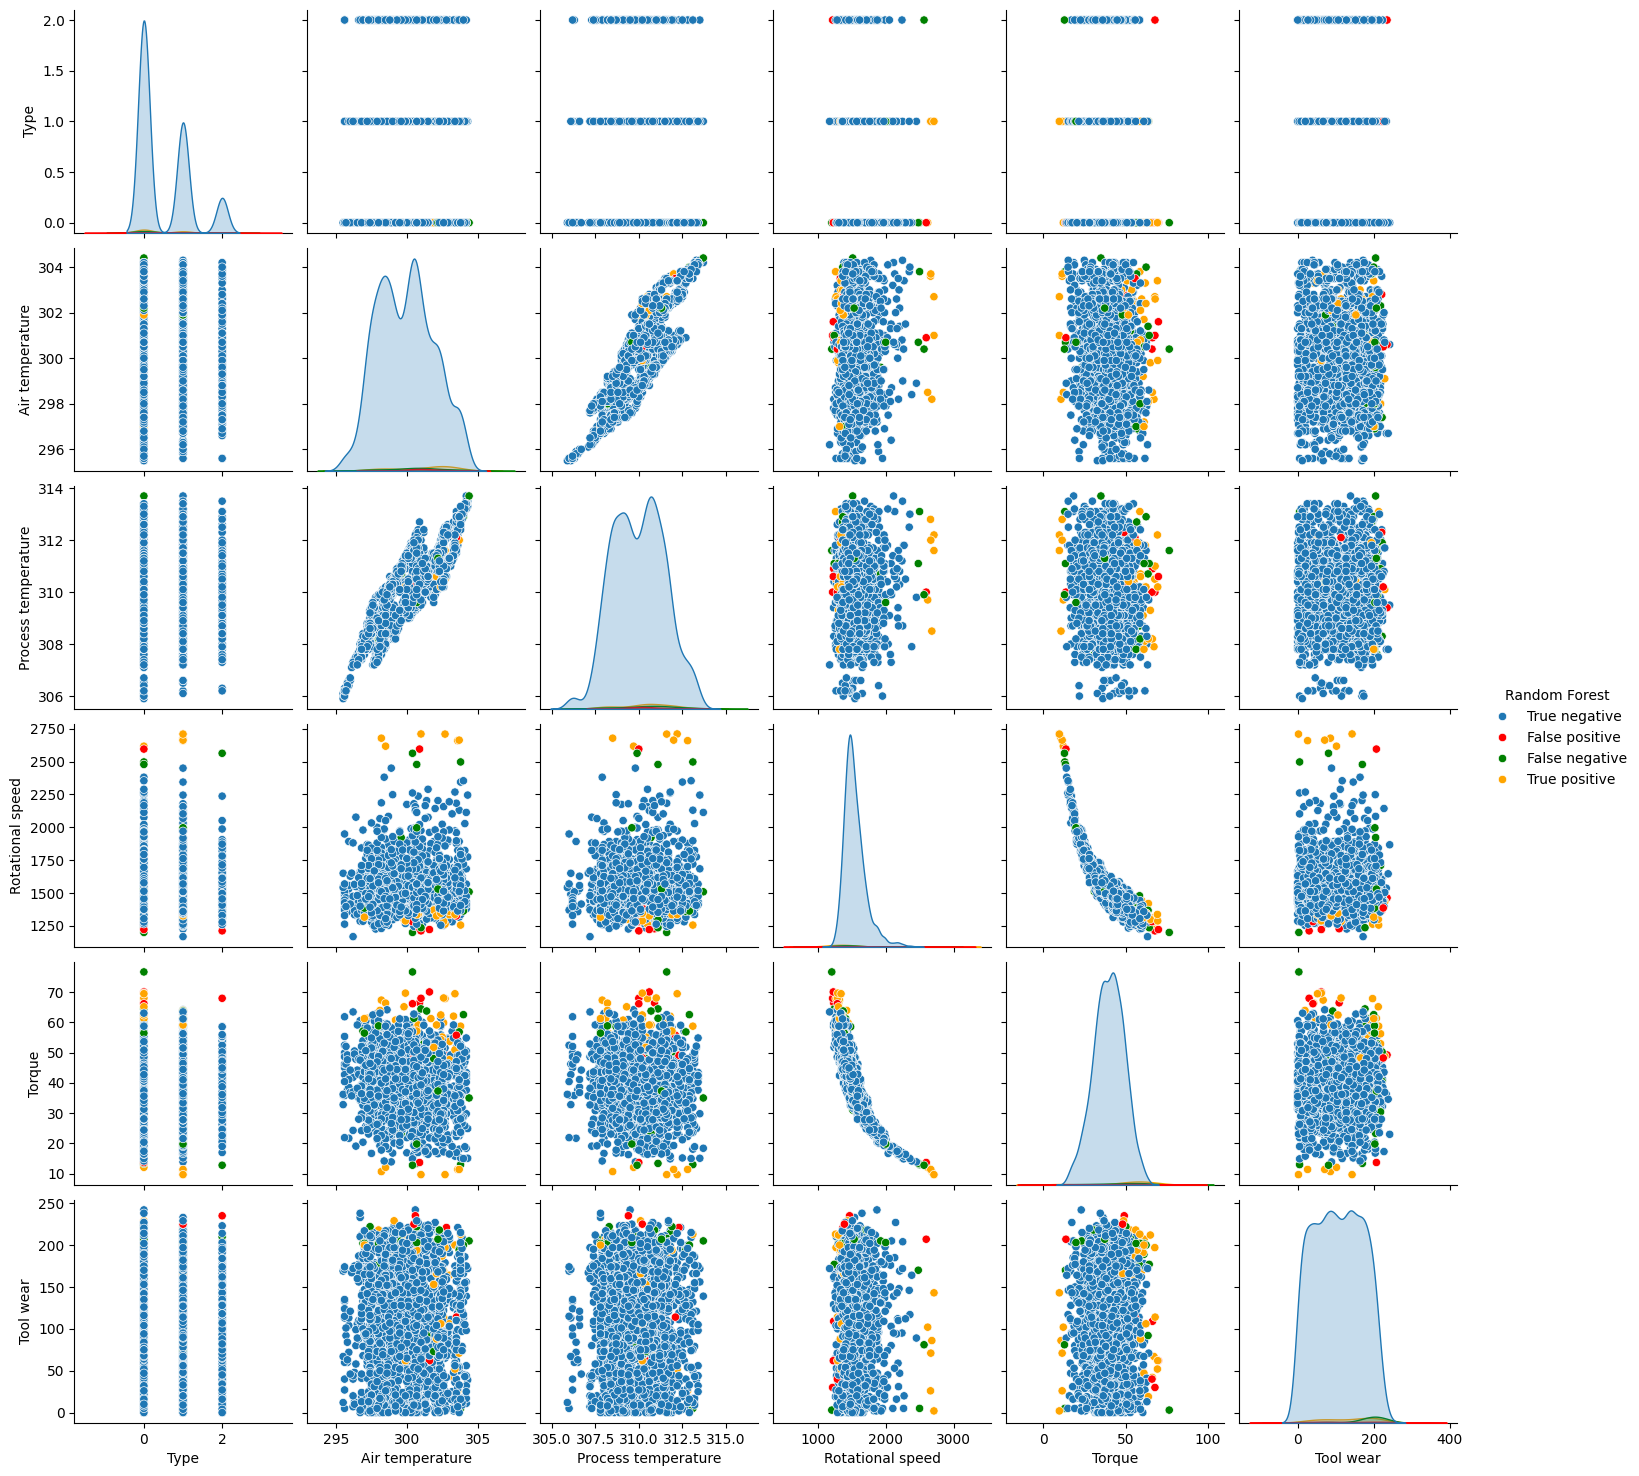

In [40]:
# Plot feature pairs
sns.pairplot(x_rforest, 
             hue='Random Forest', 
             hue_order=['True negative', 'False positive','False negative', 'True positive'],
             palette=['#1f77b4', 'red', 'green', 'orange'])

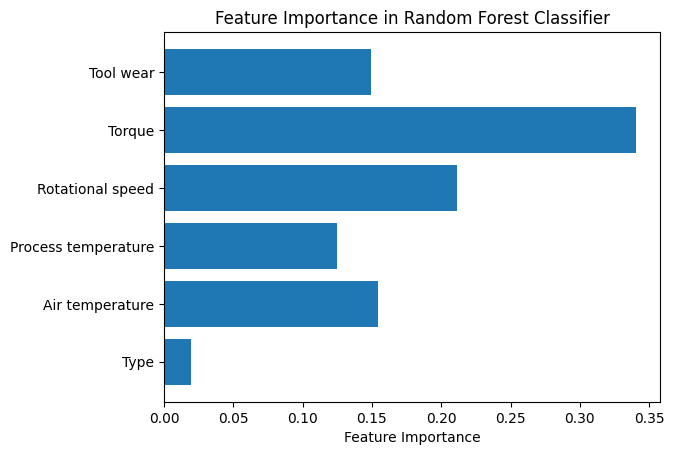

In [41]:
feature_importances = best_rforest.feature_importances_

plt.barh(xtrain.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

# Comparison of algorithm results

In [42]:
# Generate the training, validation, test results from the three algorithms.
print('kNN algorithm:')
print('  Training set validation score ' + str(max(mean_val_scores.tolist())))
print('  Test set score ' + str(recall_knn))
print('Decision Tree algorithm:')
print('  Training set validation score ' + str(grid_search_dtree.best_score_))
print('  Test set score ' + str(recall_dtree))
print('Random Forest algorithm:')
print('  Training set validation score ' + str(grid_search_rforest.best_score_))
print('  Test set score ' + str(recall_rforest))

kNN algorithm:
  Training set validation score 0.23265993265993265
  Test set score 0.25
Decision Tree algorithm:
  Training set validation score 0.7237037037037037
  Test set score 0.6029411764705882
Random Forest algorithm:
  Training set validation score 0.6608754208754208
  Test set score 0.5882352941176471
